# Train LSTM model to Enduro sequence games

## Load libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import csv
import os
import cv2
from PIL import Image
from enduro_lstm import *
import time

## Set to GPU if available

In [2]:
use_cuda = False
device = conf_cuda(use_cuda)

Selected CPU


In [3]:
torch.cuda.empty_cache()

In [4]:
"""import gc
del model, X_train, Y_train
gc.collect()"""

'import gc\ndel model, X_train, Y_train\ngc.collect()'

In [5]:
"""torch.cuda.memory_summary(device=None, abbreviated=False)"""

'torch.cuda.memory_summary(device=None, abbreviated=False)'

## Set configurations

In [7]:
obs = 'play'
if obs == 'zigzag':
    zigzag = True
else:
    zigzag = False
zigzag

False

In [29]:
data_path = r"../1-generate/data/"
n_epochs = 5000
hidden_neurons = 200
stop_train = 1e-5

start_match = 35
end_match = 35

start_frame = 1
end_frame = 120

In [30]:
model_name = f"{obs}_m{start_match}to{end_match}_f{start_frame}to{end_frame}_epoch{n_epochs}_H{hidden_neurons}"
newpath = f"models/" + model_name
if not os.path.exists(newpath):
    print(f"models/" + model_name + " created")
    os.makedirs(newpath)
else:
    print(f"models/" + model_name)
    print("ATTENTION! folder not created. Training informations will overwrite the existing one")

models/play_m35to35_f1to120_epoch5000_H200 created


## Load frames and targets

In [31]:
ACTIONS_LIST = get_actions_list(zigzag=zigzag)
ACTIONS_LIST

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [32]:
num_of_frames_arr = []
frames_arr = []
actions_arr = []

for m in range(start_match, end_match + 1):
    
    num_of_frames, frames, actions, rewards, lifes = load_npz(data_path, m)
    frames = frames[start_frame - 1:end_frame]
    actions = actions[start_frame - 1:end_frame]
    
    action_one_hot = [prepare_action_data(i, ACTIONS_LIST) for i in actions]
    actions = np.array(action_one_hot)
    actions = actions.reshape(len(actions), -1)
    
    frames_arr.append(frames)
    actions_arr.append(actions)
    num_of_frames_arr.append(end_frame - start_frame + 1) 

Successfully loaded NPZ.


In [33]:
X_train = np.array(frames_arr)/255
Y_train = np.array(actions_arr)
num_of_frames_arr = np.array(num_of_frames_arr)

In [34]:
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()

In [35]:
# We'll also set the model to the device that we defined earlier (default is CPU)
if use_cuda:
    model.cuda()
    X_train = X_train.cuda() 
    Y_train = Y_train.cuda()

## Create model

In [36]:
model = Model(device=device, input_size=20400, output_size=len(ACTIONS_LIST), hidden_dim=hidden_neurons, n_layers=1)

In [37]:
min_loss = 1e-05
# Define Loss, Optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters())

## Model train

In [85]:
def get_acc(predicted, target):
    
    predicted = torch.argmax(predicted, axis=1)
    target = torch.argmax(target, axis=1)
    
    correct = torch.sum(predicted == target)
    
    acc = correct/predicted.shape[0]
    return float(acc)

In [87]:
def print_epoch(epoch, n_epochs, train_loss, train_acc, valid_loss, valid_acc):
    print('Epoch: {}/{}-------------------------------------------'.format(epoch, n_epochs))
    print("Train -> Loss: {:.15f} Acc: {:.15f}".format(train_loss, train_acc))
    print("Valid -> Loss: {:.15f} Acc: {:.15f}".format(valid_loss, valid_acc))

In [ ]:
def print_file(loss_file, epoch, n_epochs, train_loss_arr[-1], train_acc_arr[-1], valid_loss_mean_arr[-1], valid_acc_mean_arr[-1]):
    loss_file.write("Epoch: {}/{}-------------------------------------------\n".format(epoch, n_epochs))
    loss_file.write("Train    -> Loss: {:.15f} Acc: {:.15f}\n".format(train_loss, train_acc))
    loss_file.write("Valid{} -> Loss: {:.15f} Acc: {:.15f}\n".format(test_idx, valid_loss, valid_acc))
    return loss_file

In [96]:
train_loss_arr = np.array([])
train_acc_arr = np.array([])
valid_loss_arr = np.array([])
valid_acc_arr = np.array([])
valid_loss_mean_arr = np.array([])
valid_acc_mean_arr = np.array([])

first_epoch = True
loss_file = open(newpath + '/' + "loss_file.txt", "w")
start_time_processing = time.time()
for epoch in range(1, n_epochs + 1):
    model.train()

    optimizer.zero_grad()
    # X_train.to(device)
    output, hidden = model(X_train)
    loss = criterion(output, Y_train.view(-1,len(ACTIONS_LIST)).float())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordinglyw
    
    train_loss_arr = np.append(train_loss_arr, loss.item())
    train_acc_arr  = np.append( train_acc_arr, get_acc(output, Y_train.reshape(-1, len(ACTIONS_LIST))) )
    
    model.eval()
    
    epoch_valid_losses = np.array([])
    epoch_valid_acc = np.array([])
    for seq in range(len(X_train)):
        output, hidden = model(torch.unsqueeze(X_train[seq], 1))
        loss = criterion(output, Y_train[seq].view(-1,len(ACTIONS_LIST)).float())
        epoch_valid_losses = np.append(epoch_valid_losses, loss.item())
        epoch_valid_acc = np.append( epoch_valid_acc, get_acc(output, Y_train[seq].reshape(-1, len(ACTIONS_LIST))) )
        
    if first_epoch:
        valid_loss_arr = epoch_valid_losses.reshape(-1, 1)
        valid_acc_arr = epoch_valid_acc.reshape(-1, 1)
        first_epoch = False
    else:
        valid_loss_arr = np.insert(valid_loss_arr, valid_loss_arr.shape[1], epoch_valid_losses, axis=1)
        valid_acc_arr = np.insert(valid_acc_arr, valid_acc_arr.shape[1], epoch_valid_acc, axis=1)
        
    valid_loss_mean_arr = np.append(valid_loss_mean_arr, np.mean(epoch_valid_losses))
    valid_acc_mean_arr = np.append(valid_acc_mean_arr, np.mean(epoch_valid_acc))
    
    print_epoch(epoch, n_epochs, train_loss_arr[-1], train_acc_arr[-1], valid_loss_mean_arr[-1], valid_acc_mean_arr[-1])
    
    loss_file.write("Epoch: {}/{}-------------------------------------------\n".format(epoch, n_epochs))
    loss_file.write("Train -> Loss: {:.15f} Acc: {:.15f}\n".format(train_loss_arr[-1], train_acc_arr[-1]))
    loss_file.write("Valid -> Loss: {:.15f} Acc: {:.15f}\n".format(valid_loss_mean_arr[-1], valid_acc_mean_arr[-1]))
    
loss_file.close()
np.savez(newpath + '/' + "train_loss_arr", train_loss_arr)
np.savez(newpath + '/' + "test_loss_arr", test_loss_arr)
print("--- %s seconds ---" % (time.time() - start_time_processing))

Epoch: 1/5000-------------------------------------------
Train -> Loss: 0.054641470313072 Acc: 0.741666674613953
Valid -> Loss: 0.057768907397985 Acc: 0.500000000000000
Epoch: 2/5000-------------------------------------------
Train -> Loss: 0.054620865732431 Acc: 0.741666674613953
Valid -> Loss: 0.057751663029194 Acc: 0.500000000000000
Epoch: 3/5000-------------------------------------------
Train -> Loss: 0.054600145667791 Acc: 0.741666674613953
Valid -> Loss: 0.057735700160265 Acc: 0.500000000000000
Epoch: 4/5000-------------------------------------------
Train -> Loss: 0.054579593241215 Acc: 0.741666674613953
Valid -> Loss: 0.057719845324755 Acc: 0.500000000000000
Epoch: 5/5000-------------------------------------------
Train -> Loss: 0.054559197276831 Acc: 0.741666674613953
Valid -> Loss: 0.057703759521246 Acc: 0.500000000000000
Epoch: 6/5000-------------------------------------------
Train -> Loss: 0.054538782685995 Acc: 0.741666674613953
Valid -> Loss: 0.057688087224960 Acc: 0.50

Epoch: 50/5000-------------------------------------------
Train -> Loss: 0.053745690733194 Acc: 0.741666674613953
Valid -> Loss: 0.057183295488358 Acc: 0.500000000000000
Epoch: 51/5000-------------------------------------------
Train -> Loss: 0.053729295730591 Acc: 0.741666674613953
Valid -> Loss: 0.057175539433956 Acc: 0.500000000000000
Epoch: 52/5000-------------------------------------------
Train -> Loss: 0.053712952882051 Acc: 0.741666674613953
Valid -> Loss: 0.057167895138264 Acc: 0.500000000000000
Epoch: 53/5000-------------------------------------------
Train -> Loss: 0.053696673363447 Acc: 0.741666674613953
Valid -> Loss: 0.057160347700119 Acc: 0.500000000000000
Epoch: 54/5000-------------------------------------------
Train -> Loss: 0.053680445998907 Acc: 0.741666674613953
Valid -> Loss: 0.057152930647135 Acc: 0.500000000000000
Epoch: 55/5000-------------------------------------------
Train -> Loss: 0.053664278239012 Acc: 0.741666674613953
Valid -> Loss: 0.057145636528730 Acc

Epoch: 99/5000-------------------------------------------
Train -> Loss: 0.052995864301920 Acc: 0.741666674613953
Valid -> Loss: 0.056909520179033 Acc: 0.508333325386047
Epoch: 100/5000-------------------------------------------
Train -> Loss: 0.052981480956078 Acc: 0.741666674613953
Valid -> Loss: 0.056905888020992 Acc: 0.508333325386047
Epoch: 101/5000-------------------------------------------
Train -> Loss: 0.052967134863138 Acc: 0.741666674613953
Valid -> Loss: 0.056902315467596 Acc: 0.508333325386047
Epoch: 102/5000-------------------------------------------
Train -> Loss: 0.052952811121941 Acc: 0.741666674613953
Valid -> Loss: 0.056898824870586 Acc: 0.508333325386047
Epoch: 103/5000-------------------------------------------
Train -> Loss: 0.052938520908356 Acc: 0.741666674613953
Valid -> Loss: 0.056895382702351 Acc: 0.508333325386047
Epoch: 104/5000-------------------------------------------
Train -> Loss: 0.052924256771803 Acc: 0.741666674613953
Valid -> Loss: 0.05689201503992

Epoch: 147/5000-------------------------------------------
Train -> Loss: 0.052334889769554 Acc: 0.741666674613953
Valid -> Loss: 0.056797910481691 Acc: 0.500000000000000
Epoch: 148/5000-------------------------------------------
Train -> Loss: 0.052321672439575 Acc: 0.741666674613953
Valid -> Loss: 0.056796699762344 Acc: 0.500000000000000
Epoch: 149/5000-------------------------------------------
Train -> Loss: 0.052308458834887 Acc: 0.741666674613953
Valid -> Loss: 0.056795530021191 Acc: 0.500000000000000
Epoch: 150/5000-------------------------------------------
Train -> Loss: 0.052295282483101 Acc: 0.741666674613953
Valid -> Loss: 0.056794393807650 Acc: 0.500000000000000
Epoch: 151/5000-------------------------------------------
Train -> Loss: 0.052282109856606 Acc: 0.741666674613953
Valid -> Loss: 0.056793294847012 Acc: 0.500000000000000
Epoch: 152/5000-------------------------------------------
Train -> Loss: 0.052268959581852 Acc: 0.741666674613953
Valid -> Loss: 0.0567922256886

Epoch: 195/5000-------------------------------------------
Train -> Loss: 0.051719162613153 Acc: 0.741666674613953
Valid -> Loss: 0.056773617863655 Acc: 0.500000000000000
Epoch: 196/5000-------------------------------------------
Train -> Loss: 0.051706705242395 Acc: 0.741666674613953
Valid -> Loss: 0.056773718446493 Acc: 0.500000000000000
Epoch: 197/5000-------------------------------------------
Train -> Loss: 0.051694259047508 Acc: 0.741666674613953
Valid -> Loss: 0.056773833930492 Acc: 0.500000000000000
Epoch: 198/5000-------------------------------------------
Train -> Loss: 0.051681824028492 Acc: 0.741666674613953
Valid -> Loss: 0.056773968040943 Acc: 0.500000000000000
Epoch: 199/5000-------------------------------------------
Train -> Loss: 0.051669403910637 Acc: 0.741666674613953
Valid -> Loss: 0.056774128228426 Acc: 0.500000000000000
Epoch: 200/5000-------------------------------------------
Train -> Loss: 0.051656998693943 Acc: 0.741666674613953
Valid -> Loss: 0.0567743070423

Epoch: 243/5000-------------------------------------------
Train -> Loss: 0.051134351640940 Acc: 0.750000000000000
Valid -> Loss: 0.056795839220285 Acc: 0.508333325386047
Epoch: 244/5000-------------------------------------------
Train -> Loss: 0.051122389733791 Acc: 0.750000000000000
Valid -> Loss: 0.056796371936798 Acc: 0.508333325386047
Epoch: 245/5000-------------------------------------------
Train -> Loss: 0.051110409200191 Acc: 0.750000000000000
Valid -> Loss: 0.056796874850988 Acc: 0.508333325386047
Epoch: 246/5000-------------------------------------------
Train -> Loss: 0.051098443567753 Acc: 0.750000000000000
Valid -> Loss: 0.056797359138727 Acc: 0.508333325386047
Epoch: 247/5000-------------------------------------------
Train -> Loss: 0.051086477935314 Acc: 0.750000000000000
Valid -> Loss: 0.056797798722982 Acc: 0.508333325386047
Epoch: 248/5000-------------------------------------------
Train -> Loss: 0.051074508577585 Acc: 0.750000000000000
Valid -> Loss: 0.0567982047796

Epoch: 291/5000-------------------------------------------
Train -> Loss: 0.049636416137218 Acc: 0.750000000000000
Valid -> Loss: 0.056047499179840 Acc: 0.508333325386047
Epoch: 292/5000-------------------------------------------
Train -> Loss: 0.049552742391825 Acc: 0.750000000000000
Valid -> Loss: 0.056153073906898 Acc: 0.508333325386047
Epoch: 293/5000-------------------------------------------
Train -> Loss: 0.049535050988197 Acc: 0.750000000000000
Valid -> Loss: 0.055901452898979 Acc: 0.516666650772095
Epoch: 294/5000-------------------------------------------
Train -> Loss: 0.049510326236486 Acc: 0.750000000000000
Valid -> Loss: 0.056087918579578 Acc: 0.508333325386047
Epoch: 295/5000-------------------------------------------
Train -> Loss: 0.049398668110371 Acc: 0.750000000000000
Valid -> Loss: 0.055914077907801 Acc: 0.508333325386047
Epoch: 296/5000-------------------------------------------
Train -> Loss: 0.049285423010588 Acc: 0.750000000000000
Valid -> Loss: 0.0558385737240

Epoch: 339/5000-------------------------------------------
Train -> Loss: 0.046016871929169 Acc: 0.750000000000000
Valid -> Loss: 0.053958646953106 Acc: 0.516666650772095
Epoch: 340/5000-------------------------------------------
Train -> Loss: 0.045955456793308 Acc: 0.750000000000000
Valid -> Loss: 0.054370149970055 Acc: 0.516666650772095
Epoch: 341/5000-------------------------------------------
Train -> Loss: 0.045888680964708 Acc: 0.750000000000000
Valid -> Loss: 0.053850740194321 Acc: 0.516666650772095
Epoch: 342/5000-------------------------------------------
Train -> Loss: 0.045813128352165 Acc: 0.750000000000000
Valid -> Loss: 0.054265942424536 Acc: 0.516666650772095
Epoch: 343/5000-------------------------------------------
Train -> Loss: 0.045723985880613 Acc: 0.758333325386047
Valid -> Loss: 0.053851764649153 Acc: 0.516666650772095
Epoch: 344/5000-------------------------------------------
Train -> Loss: 0.045630760490894 Acc: 0.750000000000000
Valid -> Loss: 0.0540317259728

Epoch: 387/5000-------------------------------------------
Train -> Loss: 0.042523141950369 Acc: 0.966666638851166
Valid -> Loss: 0.052588265389204 Acc: 0.516666650772095
Epoch: 388/5000-------------------------------------------
Train -> Loss: 0.042455334216356 Acc: 0.958333313465118
Valid -> Loss: 0.052632249891758 Acc: 0.516666650772095
Epoch: 389/5000-------------------------------------------
Train -> Loss: 0.042388811707497 Acc: 0.966666638851166
Valid -> Loss: 0.052622012794018 Acc: 0.516666650772095
Epoch: 390/5000-------------------------------------------
Train -> Loss: 0.042323514819145 Acc: 0.966666638851166
Valid -> Loss: 0.052508015185595 Acc: 0.516666650772095
Epoch: 391/5000-------------------------------------------
Train -> Loss: 0.042259156703949 Acc: 0.966666638851166
Valid -> Loss: 0.052637703716755 Acc: 0.516666650772095
Epoch: 392/5000-------------------------------------------
Train -> Loss: 0.042195305228233 Acc: 0.975000023841858
Valid -> Loss: 0.0524144843220

Epoch: 435/5000-------------------------------------------
Train -> Loss: 0.039639249444008 Acc: 0.991666674613953
Valid -> Loss: 0.051702953875065 Acc: 0.516666650772095
Epoch: 436/5000-------------------------------------------
Train -> Loss: 0.039584986865520 Acc: 0.991666674613953
Valid -> Loss: 0.051715642213821 Acc: 0.516666650772095
Epoch: 437/5000-------------------------------------------
Train -> Loss: 0.039530921727419 Acc: 0.991666674613953
Valid -> Loss: 0.051680855453014 Acc: 0.516666650772095
Epoch: 438/5000-------------------------------------------
Train -> Loss: 0.039477061480284 Acc: 0.991666674613953
Valid -> Loss: 0.051677443087101 Acc: 0.516666650772095
Epoch: 439/5000-------------------------------------------
Train -> Loss: 0.039423413574696 Acc: 0.991666674613953
Valid -> Loss: 0.051666125655174 Acc: 0.516666650772095
Epoch: 440/5000-------------------------------------------
Train -> Loss: 0.039369985461235 Acc: 0.991666674613953
Valid -> Loss: 0.0516399666666

Epoch: 483/5000-------------------------------------------
Train -> Loss: 0.037251401692629 Acc: 0.991666674613953
Valid -> Loss: 0.051229164004326 Acc: 0.516666650772095
Epoch: 484/5000-------------------------------------------
Train -> Loss: 0.037205878645182 Acc: 0.991666674613953
Valid -> Loss: 0.051223967224360 Acc: 0.516666650772095
Epoch: 485/5000-------------------------------------------
Train -> Loss: 0.037160512059927 Acc: 0.991666674613953
Valid -> Loss: 0.051217891275883 Acc: 0.516666650772095
Epoch: 486/5000-------------------------------------------
Train -> Loss: 0.037115294486284 Acc: 0.991666674613953
Valid -> Loss: 0.051210027188063 Acc: 0.516666650772095
Epoch: 487/5000-------------------------------------------
Train -> Loss: 0.037070225924253 Acc: 0.991666674613953
Valid -> Loss: 0.051205690950155 Acc: 0.516666650772095
Epoch: 488/5000-------------------------------------------
Train -> Loss: 0.037025306373835 Acc: 0.991666674613953
Valid -> Loss: 0.0511988848447

Epoch: 531/5000-------------------------------------------
Train -> Loss: 0.035223472863436 Acc: 0.991666674613953
Valid -> Loss: 0.051016993820667 Acc: 0.524999976158142
Epoch: 532/5000-------------------------------------------
Train -> Loss: 0.035184364765882 Acc: 0.991666674613953
Valid -> Loss: 0.051066379994154 Acc: 0.524999976158142
Epoch: 533/5000-------------------------------------------
Train -> Loss: 0.035145241767168 Acc: 0.991666674613953
Valid -> Loss: 0.051059026271105 Acc: 0.524999976158142
Epoch: 534/5000-------------------------------------------
Train -> Loss: 0.035106215626001 Acc: 0.991666674613953
Valid -> Loss: 0.051038425415754 Acc: 0.524999976158142
Epoch: 535/5000-------------------------------------------
Train -> Loss: 0.035067413002253 Acc: 0.991666674613953
Valid -> Loss: 0.051079787313938 Acc: 0.524999976158142
Epoch: 536/5000-------------------------------------------
Train -> Loss: 0.035028640180826 Acc: 0.991666674613953
Valid -> Loss: 0.0510583184659

Epoch: 579/5000-------------------------------------------
Train -> Loss: 0.033457651734352 Acc: 0.991666674613953
Valid -> Loss: 0.051097191870213 Acc: 0.524999976158142
Epoch: 580/5000-------------------------------------------
Train -> Loss: 0.033423151820898 Acc: 0.991666674613953
Valid -> Loss: 0.051098298281431 Acc: 0.524999976158142
Epoch: 581/5000-------------------------------------------
Train -> Loss: 0.033388733863831 Acc: 0.991666674613953
Valid -> Loss: 0.051097154617310 Acc: 0.524999976158142
Epoch: 582/5000-------------------------------------------
Train -> Loss: 0.033354401588440 Acc: 0.991666674613953
Valid -> Loss: 0.051102899014950 Acc: 0.524999976158142
Epoch: 583/5000-------------------------------------------
Train -> Loss: 0.033320154994726 Acc: 0.991666674613953
Valid -> Loss: 0.051107175648212 Acc: 0.524999976158142
Epoch: 584/5000-------------------------------------------
Train -> Loss: 0.033285994082689 Acc: 0.991666674613953
Valid -> Loss: 0.0511076450347

Epoch: 627/5000-------------------------------------------
Train -> Loss: 0.031887814402580 Acc: 0.991666674613953
Valid -> Loss: 0.051347292959690 Acc: 0.524999976158142
Epoch: 628/5000-------------------------------------------
Train -> Loss: 0.031856730580330 Acc: 0.991666674613953
Valid -> Loss: 0.051356226205826 Acc: 0.524999976158142
Epoch: 629/5000-------------------------------------------
Train -> Loss: 0.031825691461563 Acc: 0.991666674613953
Valid -> Loss: 0.051365513354540 Acc: 0.524999976158142
Epoch: 630/5000-------------------------------------------
Train -> Loss: 0.031794704496861 Acc: 0.991666674613953
Valid -> Loss: 0.051375534385443 Acc: 0.524999976158142
Epoch: 631/5000-------------------------------------------
Train -> Loss: 0.031763765960932 Acc: 0.991666674613953
Valid -> Loss: 0.051385588943958 Acc: 0.524999976158142
Epoch: 632/5000-------------------------------------------
Train -> Loss: 0.031732868403196 Acc: 0.991666674613953
Valid -> Loss: 0.0513957180082

Epoch: 675/5000-------------------------------------------
Train -> Loss: 0.030255841091275 Acc: 0.991666674613953
Valid -> Loss: 0.052287440747023 Acc: 0.524999976158142
Epoch: 676/5000-------------------------------------------
Train -> Loss: 0.030216887593269 Acc: 1.000000000000000
Valid -> Loss: 0.052238821983337 Acc: 0.524999976158142
Epoch: 677/5000-------------------------------------------
Train -> Loss: 0.030178960412741 Acc: 1.000000000000000
Valid -> Loss: 0.052192863076925 Acc: 0.524999976158142
Epoch: 678/5000-------------------------------------------
Train -> Loss: 0.030141940340400 Acc: 1.000000000000000
Valid -> Loss: 0.052150610834360 Acc: 0.524999976158142
Epoch: 679/5000-------------------------------------------
Train -> Loss: 0.030105682089925 Acc: 1.000000000000000
Valid -> Loss: 0.052112553268671 Acc: 0.524999976158142
Epoch: 680/5000-------------------------------------------
Train -> Loss: 0.030070072039962 Acc: 1.000000000000000
Valid -> Loss: 0.0520790629088

Epoch: 723/5000-------------------------------------------
Train -> Loss: 0.028805023059249 Acc: 1.000000000000000
Valid -> Loss: 0.052162952721119 Acc: 0.516666650772095
Epoch: 724/5000-------------------------------------------
Train -> Loss: 0.028778148815036 Acc: 1.000000000000000
Valid -> Loss: 0.052170146256685 Acc: 0.516666650772095
Epoch: 725/5000-------------------------------------------
Train -> Loss: 0.028751343488693 Acc: 1.000000000000000
Valid -> Loss: 0.052177257835865 Acc: 0.516666650772095
Epoch: 726/5000-------------------------------------------
Train -> Loss: 0.028724592179060 Acc: 1.000000000000000
Valid -> Loss: 0.052184365689754 Acc: 0.516666650772095
Epoch: 727/5000-------------------------------------------
Train -> Loss: 0.028697909787297 Acc: 1.000000000000000
Valid -> Loss: 0.052191436290741 Acc: 0.516666650772095
Epoch: 728/5000-------------------------------------------
Train -> Loss: 0.028671283274889 Acc: 1.000000000000000
Valid -> Loss: 0.0521983765065

Epoch: 771/5000-------------------------------------------
Train -> Loss: 0.027576236054301 Acc: 1.000000000000000
Valid -> Loss: 0.052517447620630 Acc: 0.516666650772095
Epoch: 772/5000-------------------------------------------
Train -> Loss: 0.027551809325814 Acc: 1.000000000000000
Valid -> Loss: 0.052525427192450 Acc: 0.516666650772095
Epoch: 773/5000-------------------------------------------
Train -> Loss: 0.027527427300811 Acc: 1.000000000000000
Valid -> Loss: 0.052533388137817 Acc: 0.516666650772095
Epoch: 774/5000-------------------------------------------
Train -> Loss: 0.027503089979291 Acc: 1.000000000000000
Valid -> Loss: 0.052541397511959 Acc: 0.516666650772095
Epoch: 775/5000-------------------------------------------
Train -> Loss: 0.027478797361255 Acc: 1.000000000000000
Valid -> Loss: 0.052549421787262 Acc: 0.516666650772095
Epoch: 776/5000-------------------------------------------
Train -> Loss: 0.027454538270831 Acc: 1.000000000000000
Valid -> Loss: 0.0525574795901

Epoch: 819/5000-------------------------------------------
Train -> Loss: 0.026450222358108 Acc: 1.000000000000000
Valid -> Loss: 0.052929468452930 Acc: 0.516666650772095
Epoch: 820/5000-------------------------------------------
Train -> Loss: 0.026427712291479 Acc: 1.000000000000000
Valid -> Loss: 0.052938610315323 Acc: 0.516666650772095
Epoch: 821/5000-------------------------------------------
Train -> Loss: 0.026405239477754 Acc: 1.000000000000000
Valid -> Loss: 0.052947778254747 Acc: 0.516666650772095
Epoch: 822/5000-------------------------------------------
Train -> Loss: 0.026382807642221 Acc: 1.000000000000000
Valid -> Loss: 0.052957024425268 Acc: 0.516666650772095
Epoch: 823/5000-------------------------------------------
Train -> Loss: 0.026360407471657 Acc: 1.000000000000000
Valid -> Loss: 0.052966263145208 Acc: 0.516666650772095
Epoch: 824/5000-------------------------------------------
Train -> Loss: 0.026338040828705 Acc: 1.000000000000000
Valid -> Loss: 0.0529754981398

Epoch: 867/5000-------------------------------------------
Train -> Loss: 0.025409154593945 Acc: 1.000000000000000
Valid -> Loss: 0.053392127156258 Acc: 0.516666650772095
Epoch: 868/5000-------------------------------------------
Train -> Loss: 0.025388278067112 Acc: 1.000000000000000
Valid -> Loss: 0.053402192890644 Acc: 0.516666650772095
Epoch: 869/5000-------------------------------------------
Train -> Loss: 0.025367429479957 Acc: 1.000000000000000
Valid -> Loss: 0.053412258625031 Acc: 0.516666650772095
Epoch: 870/5000-------------------------------------------
Train -> Loss: 0.025346620008349 Acc: 1.000000000000000
Valid -> Loss: 0.053422428667545 Acc: 0.516666650772095
Epoch: 871/5000-------------------------------------------
Train -> Loss: 0.025325840339065 Acc: 1.000000000000000
Valid -> Loss: 0.053432572633028 Acc: 0.516666650772095
Epoch: 872/5000-------------------------------------------
Train -> Loss: 0.025305086746812 Acc: 1.000000000000000
Valid -> Loss: 0.0534426942467

Epoch: 915/5000-------------------------------------------
Train -> Loss: 0.024441214278340 Acc: 1.000000000000000
Valid -> Loss: 0.053893513977528 Acc: 0.516666650772095
Epoch: 916/5000-------------------------------------------
Train -> Loss: 0.024421757087111 Acc: 1.000000000000000
Valid -> Loss: 0.053904328495264 Acc: 0.516666650772095
Epoch: 917/5000-------------------------------------------
Train -> Loss: 0.024402329698205 Acc: 1.000000000000000
Valid -> Loss: 0.053915120661259 Acc: 0.516666650772095
Epoch: 918/5000-------------------------------------------
Train -> Loss: 0.024382930248976 Acc: 1.000000000000000
Valid -> Loss: 0.053925916552544 Acc: 0.516666650772095
Epoch: 919/5000-------------------------------------------
Train -> Loss: 0.024363553151488 Acc: 1.000000000000000
Valid -> Loss: 0.053936749696732 Acc: 0.516666650772095
Epoch: 920/5000-------------------------------------------
Train -> Loss: 0.024344205856323 Acc: 1.000000000000000
Valid -> Loss: 0.0539476126432

Epoch: 963/5000-------------------------------------------
Train -> Loss: 0.023537263274193 Acc: 1.000000000000000
Valid -> Loss: 0.054424770176411 Acc: 0.516666650772095
Epoch: 964/5000-------------------------------------------
Train -> Loss: 0.023519054055214 Acc: 1.000000000000000
Valid -> Loss: 0.054436132311821 Acc: 0.516666650772095
Epoch: 965/5000-------------------------------------------
Train -> Loss: 0.023500872775912 Acc: 1.000000000000000
Valid -> Loss: 0.054447446018457 Acc: 0.516666650772095
Epoch: 966/5000-------------------------------------------
Train -> Loss: 0.023482717573643 Acc: 1.000000000000000
Valid -> Loss: 0.054458789527416 Acc: 0.516666650772095
Epoch: 967/5000-------------------------------------------
Train -> Loss: 0.023464579135180 Acc: 1.000000000000000
Valid -> Loss: 0.054470136761665 Acc: 0.516666650772095
Epoch: 968/5000-------------------------------------------
Train -> Loss: 0.023446466773748 Acc: 1.000000000000000
Valid -> Loss: 0.0544815473258

Epoch: 1011/5000-------------------------------------------
Train -> Loss: 0.022689944133162 Acc: 1.000000000000000
Valid -> Loss: 0.054978985339403 Acc: 0.516666650772095
Epoch: 1012/5000-------------------------------------------
Train -> Loss: 0.022672846913338 Acc: 1.000000000000000
Valid -> Loss: 0.054990742355585 Acc: 0.516666650772095
Epoch: 1013/5000-------------------------------------------
Train -> Loss: 0.022655775770545 Acc: 1.000000000000000
Valid -> Loss: 0.055002484470606 Acc: 0.516666650772095
Epoch: 1014/5000-------------------------------------------
Train -> Loss: 0.022638721391559 Acc: 1.000000000000000
Valid -> Loss: 0.055014219135046 Acc: 0.516666650772095
Epoch: 1015/5000-------------------------------------------
Train -> Loss: 0.022621689364314 Acc: 1.000000000000000
Valid -> Loss: 0.055026005953550 Acc: 0.516666650772095
Epoch: 1016/5000-------------------------------------------
Train -> Loss: 0.022604683414102 Acc: 1.000000000000000
Valid -> Loss: 0.0550378

Epoch: 1059/5000-------------------------------------------
Train -> Loss: 0.021893177181482 Acc: 1.000000000000000
Valid -> Loss: 0.055550627410412 Acc: 0.508333325386047
Epoch: 1060/5000-------------------------------------------
Train -> Loss: 0.021877082064748 Acc: 1.000000000000000
Valid -> Loss: 0.055562697350979 Acc: 0.508333325386047
Epoch: 1061/5000-------------------------------------------
Train -> Loss: 0.021860998123884 Acc: 1.000000000000000
Valid -> Loss: 0.055574748665094 Acc: 0.508333325386047
Epoch: 1062/5000-------------------------------------------
Train -> Loss: 0.021844936534762 Acc: 1.000000000000000
Valid -> Loss: 0.055586803704500 Acc: 0.508333325386047
Epoch: 1063/5000-------------------------------------------
Train -> Loss: 0.021828897297382 Acc: 1.000000000000000
Valid -> Loss: 0.055598873645067 Acc: 0.508333325386047
Epoch: 1064/5000-------------------------------------------
Train -> Loss: 0.021812876686454 Acc: 1.000000000000000
Valid -> Loss: 0.0556109

Epoch: 1107/5000-------------------------------------------
Train -> Loss: 0.021060541272163 Acc: 1.000000000000000
Valid -> Loss: 0.055859126150608 Acc: 0.516666650772095
Epoch: 1108/5000-------------------------------------------
Train -> Loss: 0.021035321056843 Acc: 1.000000000000000
Valid -> Loss: 0.055864538997412 Acc: 0.516666650772095
Epoch: 1109/5000-------------------------------------------
Train -> Loss: 0.021001661196351 Acc: 1.000000000000000
Valid -> Loss: 0.056131921708584 Acc: 0.508333325386047
Epoch: 1110/5000-------------------------------------------
Train -> Loss: 0.020965391770005 Acc: 1.000000000000000
Valid -> Loss: 0.056159310042858 Acc: 0.508333325386047
Epoch: 1111/5000-------------------------------------------
Train -> Loss: 0.020937636494637 Acc: 1.000000000000000
Valid -> Loss: 0.055575489997864 Acc: 0.516666650772095
Epoch: 1112/5000-------------------------------------------
Train -> Loss: 0.020901424810290 Acc: 1.000000000000000
Valid -> Loss: 0.0558987

Epoch: 1155/5000-------------------------------------------
Train -> Loss: 0.018797216936946 Acc: 1.000000000000000
Valid -> Loss: 0.054754976183176 Acc: 0.516666650772095
Epoch: 1156/5000-------------------------------------------
Train -> Loss: 0.018710980191827 Acc: 1.000000000000000
Valid -> Loss: 0.055204872041941 Acc: 0.516666650772095
Epoch: 1157/5000-------------------------------------------
Train -> Loss: 0.018606796860695 Acc: 1.000000000000000
Valid -> Loss: 0.055712167173624 Acc: 0.516666650772095
Epoch: 1158/5000-------------------------------------------
Train -> Loss: 0.018534317612648 Acc: 1.000000000000000
Valid -> Loss: 0.055973276495934 Acc: 0.508333325386047
Epoch: 1159/5000-------------------------------------------
Train -> Loss: 0.018498895689845 Acc: 1.000000000000000
Valid -> Loss: 0.056887257844210 Acc: 0.508333325386047
Epoch: 1160/5000-------------------------------------------
Train -> Loss: 0.018447956070304 Acc: 1.000000000000000
Valid -> Loss: 0.0554388

Epoch: 1203/5000-------------------------------------------
Train -> Loss: 0.015806548297405 Acc: 1.000000000000000
Valid -> Loss: 0.056133802980185 Acc: 0.508333325386047
Epoch: 1204/5000-------------------------------------------
Train -> Loss: 0.015788732096553 Acc: 1.000000000000000
Valid -> Loss: 0.054758980870247 Acc: 0.508333325386047
Epoch: 1205/5000-------------------------------------------
Train -> Loss: 0.015714064240456 Acc: 1.000000000000000
Valid -> Loss: 0.054525386542082 Acc: 0.508333325386047
Epoch: 1206/5000-------------------------------------------
Train -> Loss: 0.015676295384765 Acc: 1.000000000000000
Valid -> Loss: 0.055775742977858 Acc: 0.508333325386047
Epoch: 1207/5000-------------------------------------------
Train -> Loss: 0.015621110796928 Acc: 1.000000000000000
Valid -> Loss: 0.055704433470964 Acc: 0.508333325386047
Epoch: 1208/5000-------------------------------------------
Train -> Loss: 0.015567310154438 Acc: 1.000000000000000
Valid -> Loss: 0.0546456

Epoch: 1251/5000-------------------------------------------
Train -> Loss: 0.013760404661298 Acc: 1.000000000000000
Valid -> Loss: 0.055300958454609 Acc: 0.508333325386047
Epoch: 1252/5000-------------------------------------------
Train -> Loss: 0.013724501244724 Acc: 1.000000000000000
Valid -> Loss: 0.055280480533838 Acc: 0.508333325386047
Epoch: 1253/5000-------------------------------------------
Train -> Loss: 0.013688655570149 Acc: 1.000000000000000
Valid -> Loss: 0.055166698992252 Acc: 0.508333325386047
Epoch: 1254/5000-------------------------------------------
Train -> Loss: 0.013653201982379 Acc: 1.000000000000000
Valid -> Loss: 0.055216789245605 Acc: 0.508333325386047
Epoch: 1255/5000-------------------------------------------
Train -> Loss: 0.013617762364447 Acc: 1.000000000000000
Valid -> Loss: 0.055335402488708 Acc: 0.508333325386047
Epoch: 1256/5000-------------------------------------------
Train -> Loss: 0.013582722283900 Acc: 1.000000000000000
Valid -> Loss: 0.0552943

Epoch: 1299/5000-------------------------------------------
Train -> Loss: 0.012229893356562 Acc: 1.000000000000000
Valid -> Loss: 0.055628672242165 Acc: 0.508333325386047
Epoch: 1300/5000-------------------------------------------
Train -> Loss: 0.012146755121648 Acc: 1.000000000000000
Valid -> Loss: 0.055272322148085 Acc: 0.516666650772095
Epoch: 1301/5000-------------------------------------------
Train -> Loss: 0.012032036669552 Acc: 1.000000000000000
Valid -> Loss: 0.055332884192467 Acc: 0.508333325386047
Epoch: 1302/5000-------------------------------------------
Train -> Loss: 0.012115106917918 Acc: 1.000000000000000
Valid -> Loss: 0.055601634085178 Acc: 0.508333325386047
Epoch: 1303/5000-------------------------------------------
Train -> Loss: 0.011990567669272 Acc: 1.000000000000000
Valid -> Loss: 0.055893085896969 Acc: 0.508333325386047
Epoch: 1304/5000-------------------------------------------
Train -> Loss: 0.011947139166296 Acc: 1.000000000000000
Valid -> Loss: 0.0563750

Epoch: 1347/5000-------------------------------------------
Train -> Loss: 0.010263000614941 Acc: 1.000000000000000
Valid -> Loss: 0.055626634508371 Acc: 0.508333325386047
Epoch: 1348/5000-------------------------------------------
Train -> Loss: 0.010220510885119 Acc: 1.000000000000000
Valid -> Loss: 0.055701591074467 Acc: 0.516666650772095
Epoch: 1349/5000-------------------------------------------
Train -> Loss: 0.010142145678401 Acc: 1.000000000000000
Valid -> Loss: 0.056953456252813 Acc: 0.508333325386047
Epoch: 1350/5000-------------------------------------------
Train -> Loss: 0.010135252960026 Acc: 1.000000000000000
Valid -> Loss: 0.057290468364954 Acc: 0.508333325386047
Epoch: 1351/5000-------------------------------------------
Train -> Loss: 0.010038289241493 Acc: 1.000000000000000
Valid -> Loss: 0.056446280330420 Acc: 0.516666650772095
Epoch: 1352/5000-------------------------------------------
Train -> Loss: 0.010043449699879 Acc: 1.000000000000000
Valid -> Loss: 0.0560436

Epoch: 1395/5000-------------------------------------------
Train -> Loss: 0.008358347229660 Acc: 1.000000000000000
Valid -> Loss: 0.056864190846682 Acc: 0.516666650772095
Epoch: 1396/5000-------------------------------------------
Train -> Loss: 0.008327158167958 Acc: 1.000000000000000
Valid -> Loss: 0.056816380470991 Acc: 0.516666650772095
Epoch: 1397/5000-------------------------------------------
Train -> Loss: 0.008296210318804 Acc: 1.000000000000000
Valid -> Loss: 0.057014532387257 Acc: 0.516666650772095
Epoch: 1398/5000-------------------------------------------
Train -> Loss: 0.008265077136457 Acc: 1.000000000000000
Valid -> Loss: 0.057166758924723 Acc: 0.508333325386047
Epoch: 1399/5000-------------------------------------------
Train -> Loss: 0.008234897628427 Acc: 1.000000000000000
Valid -> Loss: 0.057045556604862 Acc: 0.516666650772095
Epoch: 1400/5000-------------------------------------------
Train -> Loss: 0.008204350247979 Acc: 1.000000000000000
Valid -> Loss: 0.0569814

Epoch: 1443/5000-------------------------------------------
Train -> Loss: 0.007084832526743 Acc: 1.000000000000000
Valid -> Loss: 0.058076024055481 Acc: 0.508333325386047
Epoch: 1444/5000-------------------------------------------
Train -> Loss: 0.007061016745865 Acc: 1.000000000000000
Valid -> Loss: 0.058153647929430 Acc: 0.508333325386047
Epoch: 1445/5000-------------------------------------------
Train -> Loss: 0.007037240546197 Acc: 1.000000000000000
Valid -> Loss: 0.058207545429468 Acc: 0.508333325386047
Epoch: 1446/5000-------------------------------------------
Train -> Loss: 0.007013449911028 Acc: 1.000000000000000
Valid -> Loss: 0.058256044983864 Acc: 0.508333325386047
Epoch: 1447/5000-------------------------------------------
Train -> Loss: 0.006989590357989 Acc: 1.000000000000000
Valid -> Loss: 0.058328222483397 Acc: 0.508333325386047
Epoch: 1448/5000-------------------------------------------
Train -> Loss: 0.006965597160161 Acc: 1.000000000000000
Valid -> Loss: 0.0584182

Epoch: 1491/5000-------------------------------------------
Train -> Loss: 0.005829854868352 Acc: 1.000000000000000
Valid -> Loss: 0.060988921672106 Acc: 0.500000000000000
Epoch: 1492/5000-------------------------------------------
Train -> Loss: 0.005806894041598 Acc: 1.000000000000000
Valid -> Loss: 0.061054646968842 Acc: 0.500000000000000
Epoch: 1493/5000-------------------------------------------
Train -> Loss: 0.005784264300019 Acc: 1.000000000000000
Valid -> Loss: 0.061110947281122 Acc: 0.500000000000000
Epoch: 1494/5000-------------------------------------------
Train -> Loss: 0.005762159358710 Acc: 1.000000000000000
Valid -> Loss: 0.061171341687441 Acc: 0.500000000000000
Epoch: 1495/5000-------------------------------------------
Train -> Loss: 0.005740688648075 Acc: 1.000000000000000
Valid -> Loss: 0.061239667236805 Acc: 0.500000000000000
Epoch: 1496/5000-------------------------------------------
Train -> Loss: 0.005719859153032 Acc: 1.000000000000000
Valid -> Loss: 0.0613278

Epoch: 1539/5000-------------------------------------------
Train -> Loss: 0.004973871633410 Acc: 1.000000000000000
Valid -> Loss: 0.061490297317505 Acc: 0.500000000000000
Epoch: 1540/5000-------------------------------------------
Train -> Loss: 0.004959315527231 Acc: 1.000000000000000
Valid -> Loss: 0.061494588851929 Acc: 0.500000000000000
Epoch: 1541/5000-------------------------------------------
Train -> Loss: 0.004944898188114 Acc: 1.000000000000000
Valid -> Loss: 0.061503235250711 Acc: 0.500000000000000
Epoch: 1542/5000-------------------------------------------
Train -> Loss: 0.004930610768497 Acc: 1.000000000000000
Valid -> Loss: 0.061515364795923 Acc: 0.500000000000000
Epoch: 1543/5000-------------------------------------------
Train -> Loss: 0.004916450940073 Acc: 1.000000000000000
Valid -> Loss: 0.061528466641903 Acc: 0.500000000000000
Epoch: 1544/5000-------------------------------------------
Train -> Loss: 0.004902407992631 Acc: 1.000000000000000
Valid -> Loss: 0.0615411

Epoch: 1587/5000-------------------------------------------
Train -> Loss: 0.004377507138997 Acc: 1.000000000000000
Valid -> Loss: 0.062111429870129 Acc: 0.500000000000000
Epoch: 1588/5000-------------------------------------------
Train -> Loss: 0.004366755485535 Acc: 1.000000000000000
Valid -> Loss: 0.062121998518705 Acc: 0.500000000000000
Epoch: 1589/5000-------------------------------------------
Train -> Loss: 0.004356058780104 Acc: 1.000000000000000
Valid -> Loss: 0.062132630497217 Acc: 0.500000000000000
Epoch: 1590/5000-------------------------------------------
Train -> Loss: 0.004345417954028 Acc: 1.000000000000000
Valid -> Loss: 0.062143348157406 Acc: 0.500000000000000
Epoch: 1591/5000-------------------------------------------
Train -> Loss: 0.004334832075983 Acc: 1.000000000000000
Valid -> Loss: 0.062154170125723 Acc: 0.500000000000000
Epoch: 1592/5000-------------------------------------------
Train -> Loss: 0.004324297420681 Acc: 1.000000000000000
Valid -> Loss: 0.0621650

Epoch: 1635/5000-------------------------------------------
Train -> Loss: 0.003916085232049 Acc: 1.000000000000000
Valid -> Loss: 0.062640592455864 Acc: 0.500000000000000
Epoch: 1636/5000-------------------------------------------
Train -> Loss: 0.003907509148121 Acc: 1.000000000000000
Valid -> Loss: 0.062651470303535 Acc: 0.500000000000000
Epoch: 1637/5000-------------------------------------------
Train -> Loss: 0.003898971248418 Acc: 1.000000000000000
Valid -> Loss: 0.062662348151207 Acc: 0.500000000000000
Epoch: 1638/5000-------------------------------------------
Train -> Loss: 0.003890471532941 Acc: 1.000000000000000
Valid -> Loss: 0.062673263251781 Acc: 0.500000000000000
Epoch: 1639/5000-------------------------------------------
Train -> Loss: 0.003882005810738 Acc: 1.000000000000000
Valid -> Loss: 0.062684141099453 Acc: 0.500000000000000
Epoch: 1640/5000-------------------------------------------
Train -> Loss: 0.003873578738421 Acc: 1.000000000000000
Valid -> Loss: 0.0626950

Epoch: 1683/5000-------------------------------------------
Train -> Loss: 0.003542044898495 Acc: 1.000000000000000
Valid -> Loss: 0.063148282468319 Acc: 0.500000000000000
Epoch: 1684/5000-------------------------------------------
Train -> Loss: 0.003534981282428 Acc: 1.000000000000000
Valid -> Loss: 0.063158571720123 Acc: 0.500000000000000
Epoch: 1685/5000-------------------------------------------
Train -> Loss: 0.003527946071699 Acc: 1.000000000000000
Valid -> Loss: 0.063168808817863 Acc: 0.500000000000000
Epoch: 1686/5000-------------------------------------------
Train -> Loss: 0.003520936938003 Acc: 1.000000000000000
Valid -> Loss: 0.063179038465023 Acc: 0.500000000000000
Epoch: 1687/5000-------------------------------------------
Train -> Loss: 0.003513954347000 Acc: 1.000000000000000
Valid -> Loss: 0.063189253211021 Acc: 0.500000000000000
Epoch: 1688/5000-------------------------------------------
Train -> Loss: 0.003506999695674 Acc: 1.000000000000000
Valid -> Loss: 0.0631994

Epoch: 1731/5000-------------------------------------------
Train -> Loss: 0.003230563830584 Acc: 1.000000000000000
Valid -> Loss: 0.063626743853092 Acc: 0.500000000000000
Epoch: 1732/5000-------------------------------------------
Train -> Loss: 0.003224615240470 Acc: 1.000000000000000
Valid -> Loss: 0.063636377453804 Acc: 0.500000000000000
Epoch: 1733/5000-------------------------------------------
Train -> Loss: 0.003218689234927 Acc: 1.000000000000000
Valid -> Loss: 0.063646018505096 Acc: 0.500000000000000
Epoch: 1734/5000-------------------------------------------
Train -> Loss: 0.003212782554328 Acc: 1.000000000000000
Valid -> Loss: 0.063655652105808 Acc: 0.500000000000000
Epoch: 1735/5000-------------------------------------------
Train -> Loss: 0.003206898923963 Acc: 1.000000000000000
Valid -> Loss: 0.063665300607681 Acc: 0.500000000000000
Epoch: 1736/5000-------------------------------------------
Train -> Loss: 0.003201030660421 Acc: 1.000000000000000
Valid -> Loss: 0.0636749

Epoch: 1779/5000-------------------------------------------
Train -> Loss: 0.002966073108837 Acc: 1.000000000000000
Valid -> Loss: 0.064077503979206 Acc: 0.500000000000000
Epoch: 1780/5000-------------------------------------------
Train -> Loss: 0.002960981102660 Acc: 1.000000000000000
Valid -> Loss: 0.064086578786373 Acc: 0.500000000000000
Epoch: 1781/5000-------------------------------------------
Train -> Loss: 0.002955903997645 Acc: 1.000000000000000
Valid -> Loss: 0.064095698297024 Acc: 0.500000000000000
Epoch: 1782/5000-------------------------------------------
Train -> Loss: 0.002950844820589 Acc: 1.000000000000000
Valid -> Loss: 0.064104817807674 Acc: 0.500000000000000
Epoch: 1783/5000-------------------------------------------
Train -> Loss: 0.002945799846202 Acc: 1.000000000000000
Valid -> Loss: 0.064113914966583 Acc: 0.500000000000000
Epoch: 1784/5000-------------------------------------------
Train -> Loss: 0.002940769540146 Acc: 1.000000000000000
Valid -> Loss: 0.0641229

Epoch: 1827/5000-------------------------------------------
Train -> Loss: 0.002738086273894 Acc: 1.000000000000000
Valid -> Loss: 0.064503051340580 Acc: 0.500000000000000
Epoch: 1828/5000-------------------------------------------
Train -> Loss: 0.002733667613938 Acc: 1.000000000000000
Valid -> Loss: 0.064511641860008 Acc: 0.500000000000000
Epoch: 1829/5000-------------------------------------------
Train -> Loss: 0.002729260828346 Acc: 1.000000000000000
Valid -> Loss: 0.064520239830017 Acc: 0.500000000000000
Epoch: 1830/5000-------------------------------------------
Train -> Loss: 0.002724867546931 Acc: 1.000000000000000
Valid -> Loss: 0.064528860151768 Acc: 0.500000000000000
Epoch: 1831/5000-------------------------------------------
Train -> Loss: 0.002720486139879 Acc: 1.000000000000000
Valid -> Loss: 0.064537465572357 Acc: 0.500000000000000
Epoch: 1832/5000-------------------------------------------
Train -> Loss: 0.002716115675867 Acc: 1.000000000000000
Valid -> Loss: 0.0645459

Epoch: 1875/5000-------------------------------------------
Train -> Loss: 0.002539181616157 Acc: 1.000000000000000
Valid -> Loss: 0.064905747771263 Acc: 0.500000000000000
Epoch: 1876/5000-------------------------------------------
Train -> Loss: 0.002535304287449 Acc: 1.000000000000000
Valid -> Loss: 0.064913935959339 Acc: 0.500000000000000
Epoch: 1877/5000-------------------------------------------
Train -> Loss: 0.002531438833103 Acc: 1.000000000000000
Valid -> Loss: 0.064922079443932 Acc: 0.500000000000000
Epoch: 1878/5000-------------------------------------------
Train -> Loss: 0.002527583856136 Acc: 1.000000000000000
Valid -> Loss: 0.064930245280266 Acc: 0.500000000000000
Epoch: 1879/5000-------------------------------------------
Train -> Loss: 0.002523737726733 Acc: 1.000000000000000
Valid -> Loss: 0.064938351511955 Acc: 0.500000000000000
Epoch: 1880/5000-------------------------------------------
Train -> Loss: 0.002519900212064 Acc: 1.000000000000000
Valid -> Loss: 0.0649464

Epoch: 1923/5000-------------------------------------------
Train -> Loss: 0.002363919513300 Acc: 1.000000000000000
Valid -> Loss: 0.065287977457047 Acc: 0.500000000000000
Epoch: 1924/5000-------------------------------------------
Train -> Loss: 0.002360488288105 Acc: 1.000000000000000
Valid -> Loss: 0.065295770764351 Acc: 0.500000000000000
Epoch: 1925/5000-------------------------------------------
Train -> Loss: 0.002357065677643 Acc: 1.000000000000000
Valid -> Loss: 0.065303556621075 Acc: 0.500000000000000
Epoch: 1926/5000-------------------------------------------
Train -> Loss: 0.002353651449084 Acc: 1.000000000000000
Valid -> Loss: 0.065311320126057 Acc: 0.500000000000000
Epoch: 1927/5000-------------------------------------------
Train -> Loss: 0.002350244903937 Acc: 1.000000000000000
Valid -> Loss: 0.065319053828716 Acc: 0.500000000000000
Epoch: 1928/5000-------------------------------------------
Train -> Loss: 0.002346848370507 Acc: 1.000000000000000
Valid -> Loss: 0.0653267

Epoch: 1971/5000-------------------------------------------
Train -> Loss: 0.002208196790889 Acc: 1.000000000000000
Valid -> Loss: 0.065652020275593 Acc: 0.500000000000000
Epoch: 1972/5000-------------------------------------------
Train -> Loss: 0.002205135533586 Acc: 1.000000000000000
Valid -> Loss: 0.065659455955029 Acc: 0.500000000000000
Epoch: 1973/5000-------------------------------------------
Train -> Loss: 0.002202082192525 Acc: 1.000000000000000
Valid -> Loss: 0.065666854381561 Acc: 0.500000000000000
Epoch: 1974/5000-------------------------------------------
Train -> Loss: 0.002199038397521 Acc: 1.000000000000000
Valid -> Loss: 0.065674223005772 Acc: 0.500000000000000
Epoch: 1975/5000-------------------------------------------
Train -> Loss: 0.002195996697992 Acc: 1.000000000000000
Valid -> Loss: 0.065681584179401 Acc: 0.500000000000000
Epoch: 1976/5000-------------------------------------------
Train -> Loss: 0.002192965243012 Acc: 1.000000000000000
Valid -> Loss: 0.0656889

Epoch: 2019/5000-------------------------------------------
Train -> Loss: 0.002068846952170 Acc: 1.000000000000000
Valid -> Loss: 0.065999589860439 Acc: 0.500000000000000
Epoch: 2020/5000-------------------------------------------
Train -> Loss: 0.002066097920761 Acc: 1.000000000000000
Valid -> Loss: 0.066006645560265 Acc: 0.500000000000000
Epoch: 2021/5000-------------------------------------------
Train -> Loss: 0.002063357038423 Acc: 1.000000000000000
Valid -> Loss: 0.066013716161251 Acc: 0.500000000000000
Epoch: 2022/5000-------------------------------------------
Train -> Loss: 0.002060620347038 Acc: 1.000000000000000
Valid -> Loss: 0.066020756959915 Acc: 0.500000000000000
Epoch: 2023/5000-------------------------------------------
Train -> Loss: 0.002057890873402 Acc: 1.000000000000000
Valid -> Loss: 0.066027782857418 Acc: 0.500000000000000
Epoch: 2024/5000-------------------------------------------
Train -> Loss: 0.002055166056380 Acc: 1.000000000000000
Valid -> Loss: 0.0660348

Epoch: 2067/5000-------------------------------------------
Train -> Loss: 0.001943375682458 Acc: 1.000000000000000
Valid -> Loss: 0.066332325339317 Acc: 0.500000000000000
Epoch: 2068/5000-------------------------------------------
Train -> Loss: 0.001940893474966 Acc: 1.000000000000000
Valid -> Loss: 0.066339097917080 Acc: 0.500000000000000
Epoch: 2069/5000-------------------------------------------
Train -> Loss: 0.001938417903148 Acc: 1.000000000000000
Valid -> Loss: 0.066345863044262 Acc: 0.500000000000000
Epoch: 2070/5000-------------------------------------------
Train -> Loss: 0.001935945823789 Acc: 1.000000000000000
Valid -> Loss: 0.066352672874928 Acc: 0.500000000000000
Epoch: 2071/5000-------------------------------------------
Train -> Loss: 0.001933479099534 Acc: 1.000000000000000
Valid -> Loss: 0.066359430551529 Acc: 0.500000000000000
Epoch: 2072/5000-------------------------------------------
Train -> Loss: 0.001931018778123 Acc: 1.000000000000000
Valid -> Loss: 0.0663661

Epoch: 2115/5000-------------------------------------------
Train -> Loss: 0.001829785993323 Acc: 1.000000000000000
Valid -> Loss: 0.066651605069637 Acc: 0.500000000000000
Epoch: 2116/5000-------------------------------------------
Train -> Loss: 0.001827534753829 Acc: 1.000000000000000
Valid -> Loss: 0.066658101975918 Acc: 0.500000000000000
Epoch: 2117/5000-------------------------------------------
Train -> Loss: 0.001825287123211 Acc: 1.000000000000000
Valid -> Loss: 0.066664598882198 Acc: 0.500000000000000
Epoch: 2118/5000-------------------------------------------
Train -> Loss: 0.001823043799959 Acc: 1.000000000000000
Valid -> Loss: 0.066671110689640 Acc: 0.500000000000000
Epoch: 2119/5000-------------------------------------------
Train -> Loss: 0.001820803619921 Acc: 1.000000000000000
Valid -> Loss: 0.066677600145340 Acc: 0.500000000000000
Epoch: 2120/5000-------------------------------------------
Train -> Loss: 0.001818570308387 Acc: 1.000000000000000
Valid -> Loss: 0.0666841

Epoch: 2163/5000-------------------------------------------
Train -> Loss: 0.001726463437080 Acc: 1.000000000000000
Valid -> Loss: 0.066958658397198 Acc: 0.500000000000000
Epoch: 2164/5000-------------------------------------------
Train -> Loss: 0.001724410220049 Acc: 1.000000000000000
Valid -> Loss: 0.066964939236641 Acc: 0.500000000000000
Epoch: 2165/5000-------------------------------------------
Train -> Loss: 0.001722360029817 Acc: 1.000000000000000
Valid -> Loss: 0.066971197724342 Acc: 0.500000000000000
Epoch: 2166/5000-------------------------------------------
Train -> Loss: 0.001720314496197 Acc: 1.000000000000000
Valid -> Loss: 0.066977441310883 Acc: 0.500000000000000
Epoch: 2167/5000-------------------------------------------
Train -> Loss: 0.001718273619190 Acc: 1.000000000000000
Valid -> Loss: 0.066983692348003 Acc: 0.500000000000000
Epoch: 2168/5000-------------------------------------------
Train -> Loss: 0.001716235419735 Acc: 1.000000000000000
Valid -> Loss: 0.0669899

Epoch: 2211/5000-------------------------------------------
Train -> Loss: 0.001632077619433 Acc: 1.000000000000000
Valid -> Loss: 0.067254543304443 Acc: 0.500000000000000
Epoch: 2212/5000-------------------------------------------
Train -> Loss: 0.001630197511986 Acc: 1.000000000000000
Valid -> Loss: 0.067260593175888 Acc: 0.500000000000000
Epoch: 2213/5000-------------------------------------------
Train -> Loss: 0.001628321595490 Acc: 1.000000000000000
Valid -> Loss: 0.067266672849655 Acc: 0.500000000000000
Epoch: 2214/5000-------------------------------------------
Train -> Loss: 0.001626448705792 Acc: 1.000000000000000
Valid -> Loss: 0.067272737622261 Acc: 0.500000000000000
Epoch: 2215/5000-------------------------------------------
Train -> Loss: 0.001624578726478 Acc: 1.000000000000000
Valid -> Loss: 0.067278817296028 Acc: 0.500000000000000
Epoch: 2216/5000-------------------------------------------
Train -> Loss: 0.001622713054530 Acc: 1.000000000000000
Valid -> Loss: 0.0672848

Epoch: 2259/5000-------------------------------------------
Train -> Loss: 0.001545523991808 Acc: 1.000000000000000
Valid -> Loss: 0.067540235817432 Acc: 0.500000000000000
Epoch: 2260/5000-------------------------------------------
Train -> Loss: 0.001543797319755 Acc: 1.000000000000000
Valid -> Loss: 0.067546084523201 Acc: 0.500000000000000
Epoch: 2261/5000-------------------------------------------
Train -> Loss: 0.001542073325254 Acc: 1.000000000000000
Valid -> Loss: 0.067551918327808 Acc: 0.500000000000000
Epoch: 2262/5000-------------------------------------------
Train -> Loss: 0.001540353056043 Acc: 1.000000000000000
Valid -> Loss: 0.067557759582996 Acc: 0.500000000000000
Epoch: 2263/5000-------------------------------------------
Train -> Loss: 0.001538634998724 Acc: 1.000000000000000
Valid -> Loss: 0.067563623189926 Acc: 0.500000000000000
Epoch: 2264/5000-------------------------------------------
Train -> Loss: 0.001536919036880 Acc: 1.000000000000000
Valid -> Loss: 0.0675694

Epoch: 2307/5000-------------------------------------------
Train -> Loss: 0.001465876004659 Acc: 1.000000000000000
Valid -> Loss: 0.067816503345966 Acc: 0.500000000000000
Epoch: 2308/5000-------------------------------------------
Train -> Loss: 0.001464284607209 Acc: 1.000000000000000
Valid -> Loss: 0.067822165787220 Acc: 0.500000000000000
Epoch: 2309/5000-------------------------------------------
Train -> Loss: 0.001462695654482 Acc: 1.000000000000000
Valid -> Loss: 0.067827835679054 Acc: 0.500000000000000
Epoch: 2310/5000-------------------------------------------
Train -> Loss: 0.001461109146476 Acc: 1.000000000000000
Valid -> Loss: 0.067833490669727 Acc: 0.500000000000000
Epoch: 2311/5000-------------------------------------------
Train -> Loss: 0.001459525083192 Acc: 1.000000000000000
Valid -> Loss: 0.067839093506336 Acc: 0.500000000000000
Epoch: 2312/5000-------------------------------------------
Train -> Loss: 0.001457943813875 Acc: 1.000000000000000
Valid -> Loss: 0.0678447

Epoch: 2355/5000-------------------------------------------
Train -> Loss: 0.001392355305143 Acc: 1.000000000000000
Valid -> Loss: 0.068083912134171 Acc: 0.500000000000000
Epoch: 2356/5000-------------------------------------------
Train -> Loss: 0.001390883699059 Acc: 1.000000000000000
Valid -> Loss: 0.068089425563812 Acc: 0.500000000000000
Epoch: 2357/5000-------------------------------------------
Train -> Loss: 0.001389414537698 Acc: 1.000000000000000
Valid -> Loss: 0.068094931542873 Acc: 0.500000000000000
Epoch: 2358/5000-------------------------------------------
Train -> Loss: 0.001387948053889 Acc: 1.000000000000000
Valid -> Loss: 0.068100430071354 Acc: 0.500000000000000
Epoch: 2359/5000-------------------------------------------
Train -> Loss: 0.001386483898386 Acc: 1.000000000000000
Valid -> Loss: 0.068105913698673 Acc: 0.500000000000000
Epoch: 2360/5000-------------------------------------------
Train -> Loss: 0.001385022536851 Acc: 1.000000000000000
Valid -> Loss: 0.0681113

Epoch: 2403/5000-------------------------------------------
Train -> Loss: 0.001324291108176 Acc: 1.000000000000000
Valid -> Loss: 0.068343460559845 Acc: 0.500000000000000
Epoch: 2404/5000-------------------------------------------
Train -> Loss: 0.001322927884758 Acc: 1.000000000000000
Valid -> Loss: 0.068348765373230 Acc: 0.500000000000000
Epoch: 2405/5000-------------------------------------------
Train -> Loss: 0.001321565941907 Acc: 1.000000000000000
Valid -> Loss: 0.068354077637196 Acc: 0.500000000000000
Epoch: 2406/5000-------------------------------------------
Train -> Loss: 0.001320206560194 Acc: 1.000000000000000
Valid -> Loss: 0.068359412252903 Acc: 0.500000000000000
Epoch: 2407/5000-------------------------------------------
Train -> Loss: 0.001318847411312 Acc: 1.000000000000000
Valid -> Loss: 0.068364746868610 Acc: 0.500000000000000
Epoch: 2408/5000-------------------------------------------
Train -> Loss: 0.001317491871305 Acc: 1.000000000000000
Valid -> Loss: 0.0683700

Epoch: 2451/5000-------------------------------------------
Train -> Loss: 0.001261116121896 Acc: 1.000000000000000
Valid -> Loss: 0.068595454096794 Acc: 0.500000000000000
Epoch: 2452/5000-------------------------------------------
Train -> Loss: 0.001259849290363 Acc: 1.000000000000000
Valid -> Loss: 0.068600647151470 Acc: 0.500000000000000
Epoch: 2453/5000-------------------------------------------
Train -> Loss: 0.001258582575247 Acc: 1.000000000000000
Valid -> Loss: 0.068605802953243 Acc: 0.500000000000000
Epoch: 2454/5000-------------------------------------------
Train -> Loss: 0.001257318421267 Acc: 1.000000000000000
Valid -> Loss: 0.068610981106758 Acc: 0.500000000000000
Epoch: 2455/5000-------------------------------------------
Train -> Loss: 0.001256055780686 Acc: 1.000000000000000
Valid -> Loss: 0.068616114556789 Acc: 0.500000000000000
Epoch: 2456/5000-------------------------------------------
Train -> Loss: 0.001254796166904 Acc: 1.000000000000000
Valid -> Loss: 0.0686212

Epoch: 2499/5000-------------------------------------------
Train -> Loss: 0.001202334649861 Acc: 1.000000000000000
Valid -> Loss: 0.068840377032757 Acc: 0.500000000000000
Epoch: 2500/5000-------------------------------------------
Train -> Loss: 0.001201152219437 Acc: 1.000000000000000
Valid -> Loss: 0.068845443427563 Acc: 0.500000000000000
Epoch: 2501/5000-------------------------------------------
Train -> Loss: 0.001199973979965 Acc: 1.000000000000000
Valid -> Loss: 0.068850465118885 Acc: 0.500000000000000
Epoch: 2502/5000-------------------------------------------
Train -> Loss: 0.001198796206154 Acc: 1.000000000000000
Valid -> Loss: 0.068855509161949 Acc: 0.500000000000000
Epoch: 2503/5000-------------------------------------------
Train -> Loss: 0.001197620411403 Acc: 1.000000000000000
Valid -> Loss: 0.068860515952110 Acc: 0.500000000000000
Epoch: 2504/5000-------------------------------------------
Train -> Loss: 0.001196445780806 Acc: 1.000000000000000
Valid -> Loss: 0.0688655

Epoch: 2547/5000-------------------------------------------
Train -> Loss: 0.001147517235950 Acc: 1.000000000000000
Valid -> Loss: 0.069078855216503 Acc: 0.500000000000000
Epoch: 2548/5000-------------------------------------------
Train -> Loss: 0.001146415830590 Acc: 1.000000000000000
Valid -> Loss: 0.069083765149117 Acc: 0.500000000000000
Epoch: 2549/5000-------------------------------------------
Train -> Loss: 0.001145314541645 Acc: 1.000000000000000
Valid -> Loss: 0.069088660180569 Acc: 0.500000000000000
Epoch: 2550/5000-------------------------------------------
Train -> Loss: 0.001144214882515 Acc: 1.000000000000000
Valid -> Loss: 0.069093570113182 Acc: 0.500000000000000
Epoch: 2551/5000-------------------------------------------
Train -> Loss: 0.001143115805462 Acc: 1.000000000000000
Valid -> Loss: 0.069098472595215 Acc: 0.500000000000000
Epoch: 2552/5000-------------------------------------------
Train -> Loss: 0.001142020337284 Acc: 1.000000000000000
Valid -> Loss: 0.0691033

Epoch: 2595/5000-------------------------------------------
Train -> Loss: 0.001096293679439 Acc: 1.000000000000000
Valid -> Loss: 0.069311156868935 Acc: 0.500000000000000
Epoch: 2596/5000-------------------------------------------
Train -> Loss: 0.001095261191949 Acc: 1.000000000000000
Valid -> Loss: 0.069315917789936 Acc: 0.500000000000000
Epoch: 2597/5000-------------------------------------------
Train -> Loss: 0.001094231731258 Acc: 1.000000000000000
Valid -> Loss: 0.069320686161518 Acc: 0.500000000000000
Epoch: 2598/5000-------------------------------------------
Train -> Loss: 0.001093203201890 Acc: 1.000000000000000
Valid -> Loss: 0.069325476884842 Acc: 0.500000000000000
Epoch: 2599/5000-------------------------------------------
Train -> Loss: 0.001092176651582 Acc: 1.000000000000000
Valid -> Loss: 0.069330252707005 Acc: 0.500000000000000
Epoch: 2600/5000-------------------------------------------
Train -> Loss: 0.001091149169952 Acc: 1.000000000000000
Valid -> Loss: 0.0693350

Epoch: 2643/5000-------------------------------------------
Train -> Loss: 0.001048331847414 Acc: 1.000000000000000
Valid -> Loss: 0.069537818431854 Acc: 0.500000000000000
Epoch: 2644/5000-------------------------------------------
Train -> Loss: 0.001047366182320 Acc: 1.000000000000000
Valid -> Loss: 0.069542482495308 Acc: 0.500000000000000
Epoch: 2645/5000-------------------------------------------
Train -> Loss: 0.001046399003826 Acc: 1.000000000000000
Valid -> Loss: 0.069547139108181 Acc: 0.500000000000000
Epoch: 2646/5000-------------------------------------------
Train -> Loss: 0.001045434502885 Acc: 1.000000000000000
Valid -> Loss: 0.069551810622215 Acc: 0.500000000000000
Epoch: 2647/5000-------------------------------------------
Train -> Loss: 0.001044472679496 Acc: 1.000000000000000
Valid -> Loss: 0.069556452333927 Acc: 0.500000000000000
Epoch: 2648/5000-------------------------------------------
Train -> Loss: 0.001043512136675 Acc: 1.000000000000000
Valid -> Loss: 0.0695610

Epoch: 2691/5000-------------------------------------------
Train -> Loss: 0.001003343495540 Acc: 1.000000000000000
Valid -> Loss: 0.069759026169777 Acc: 0.500000000000000
Epoch: 2692/5000-------------------------------------------
Train -> Loss: 0.001002436387353 Acc: 1.000000000000000
Valid -> Loss: 0.069763571023941 Acc: 0.500000000000000
Epoch: 2693/5000-------------------------------------------
Train -> Loss: 0.001001531141810 Acc: 1.000000000000000
Valid -> Loss: 0.069768123328686 Acc: 0.500000000000000
Epoch: 2694/5000-------------------------------------------
Train -> Loss: 0.001000625081360 Acc: 1.000000000000000
Valid -> Loss: 0.069772675633430 Acc: 0.500000000000000
Epoch: 2695/5000-------------------------------------------
Train -> Loss: 0.000999721349217 Acc: 1.000000000000000
Valid -> Loss: 0.069777242839336 Acc: 0.500000000000000
Epoch: 2696/5000-------------------------------------------
Train -> Loss: 0.000998818781227 Acc: 1.000000000000000
Valid -> Loss: 0.0697817

Epoch: 2739/5000-------------------------------------------
Train -> Loss: 0.000961075886153 Acc: 1.000000000000000
Valid -> Loss: 0.069975182414055 Acc: 0.500000000000000
Epoch: 2740/5000-------------------------------------------
Train -> Loss: 0.000960221863352 Acc: 1.000000000000000
Valid -> Loss: 0.069979615509510 Acc: 0.500000000000000
Epoch: 2741/5000-------------------------------------------
Train -> Loss: 0.000959369994234 Acc: 1.000000000000000
Valid -> Loss: 0.069984070956707 Acc: 0.500000000000000
Epoch: 2742/5000-------------------------------------------
Train -> Loss: 0.000958518823609 Acc: 1.000000000000000
Valid -> Loss: 0.069988518953323 Acc: 0.500000000000000
Epoch: 2743/5000-------------------------------------------
Train -> Loss: 0.000957668700721 Acc: 1.000000000000000
Valid -> Loss: 0.069992974400520 Acc: 0.500000000000000
Epoch: 2744/5000-------------------------------------------
Train -> Loss: 0.000956819567364 Acc: 1.000000000000000
Valid -> Loss: 0.0699974

Epoch: 2787/5000-------------------------------------------
Train -> Loss: 0.000921299681067 Acc: 1.000000000000000
Valid -> Loss: 0.070186547935009 Acc: 0.500000000000000
Epoch: 2788/5000-------------------------------------------
Train -> Loss: 0.000920496066101 Acc: 1.000000000000000
Valid -> Loss: 0.070190899074078 Acc: 0.500000000000000
Epoch: 2789/5000-------------------------------------------
Train -> Loss: 0.000919693906326 Acc: 1.000000000000000
Valid -> Loss: 0.070195257663727 Acc: 0.500000000000000
Epoch: 2790/5000-------------------------------------------
Train -> Loss: 0.000918891746551 Acc: 1.000000000000000
Valid -> Loss: 0.070199601352215 Acc: 0.500000000000000
Epoch: 2791/5000-------------------------------------------
Train -> Loss: 0.000918090925552 Acc: 1.000000000000000
Valid -> Loss: 0.070203967392445 Acc: 0.500000000000000
Epoch: 2792/5000-------------------------------------------
Train -> Loss: 0.000917291617952 Acc: 1.000000000000000
Valid -> Loss: 0.0702083

Epoch: 2835/5000-------------------------------------------
Train -> Loss: 0.000883813016117 Acc: 1.000000000000000
Valid -> Loss: 0.070393346250057 Acc: 0.500000000000000
Epoch: 2836/5000-------------------------------------------
Train -> Loss: 0.000883054977749 Acc: 1.000000000000000
Valid -> Loss: 0.070397630333900 Acc: 0.500000000000000
Epoch: 2837/5000-------------------------------------------
Train -> Loss: 0.000882297928911 Acc: 1.000000000000000
Valid -> Loss: 0.070401906967163 Acc: 0.500000000000000
Epoch: 2838/5000-------------------------------------------
Train -> Loss: 0.000881542044226 Acc: 1.000000000000000
Valid -> Loss: 0.070406146347523 Acc: 0.500000000000000
Epoch: 2839/5000-------------------------------------------
Train -> Loss: 0.000880786275957 Acc: 1.000000000000000
Valid -> Loss: 0.070410422980785 Acc: 0.500000000000000
Epoch: 2840/5000-------------------------------------------
Train -> Loss: 0.000880032195710 Acc: 1.000000000000000
Valid -> Loss: 0.0704146

Epoch: 2883/5000-------------------------------------------
Train -> Loss: 0.000848434574436 Acc: 1.000000000000000
Valid -> Loss: 0.070595927536488 Acc: 0.500000000000000
Epoch: 2884/5000-------------------------------------------
Train -> Loss: 0.000847718387377 Acc: 1.000000000000000
Valid -> Loss: 0.070600077509880 Acc: 0.500000000000000
Epoch: 2885/5000-------------------------------------------
Train -> Loss: 0.000847003364470 Acc: 1.000000000000000
Valid -> Loss: 0.070604257285595 Acc: 0.500000000000000
Epoch: 2886/5000-------------------------------------------
Train -> Loss: 0.000846289447509 Acc: 1.000000000000000
Valid -> Loss: 0.070608437061310 Acc: 0.500000000000000
Epoch: 2887/5000-------------------------------------------
Train -> Loss: 0.000845575879794 Acc: 1.000000000000000
Valid -> Loss: 0.070612624287605 Acc: 0.500000000000000
Epoch: 2888/5000-------------------------------------------
Train -> Loss: 0.000844863650855 Acc: 1.000000000000000
Valid -> Loss: 0.0706167

Epoch: 2931/5000-------------------------------------------
Train -> Loss: 0.000815001258161 Acc: 1.000000000000000
Valid -> Loss: 0.070794366300106 Acc: 0.500000000000000
Epoch: 2932/5000-------------------------------------------
Train -> Loss: 0.000814324535895 Acc: 1.000000000000000
Valid -> Loss: 0.070798456668854 Acc: 0.500000000000000
Epoch: 2933/5000-------------------------------------------
Train -> Loss: 0.000813648570329 Acc: 1.000000000000000
Valid -> Loss: 0.070802561938763 Acc: 0.500000000000000
Epoch: 2934/5000-------------------------------------------
Train -> Loss: 0.000812973128632 Acc: 1.000000000000000
Valid -> Loss: 0.070806689560413 Acc: 0.500000000000000
Epoch: 2935/5000-------------------------------------------
Train -> Loss: 0.000812297977973 Acc: 1.000000000000000
Valid -> Loss: 0.070810809731483 Acc: 0.500000000000000
Epoch: 2936/5000-------------------------------------------
Train -> Loss: 0.000811624166090 Acc: 1.000000000000000
Valid -> Loss: 0.0708149

Epoch: 2979/5000-------------------------------------------
Train -> Loss: 0.000783367780969 Acc: 1.000000000000000
Valid -> Loss: 0.070989042520523 Acc: 0.500000000000000
Epoch: 2980/5000-------------------------------------------
Train -> Loss: 0.000782727205660 Acc: 1.000000000000000
Valid -> Loss: 0.070993036031723 Acc: 0.500000000000000
Epoch: 2981/5000-------------------------------------------
Train -> Loss: 0.000782086513937 Acc: 1.000000000000000
Valid -> Loss: 0.070997051894665 Acc: 0.500000000000000
Epoch: 2982/5000-------------------------------------------
Train -> Loss: 0.000781447102781 Acc: 1.000000000000000
Valid -> Loss: 0.071001060307026 Acc: 0.500000000000000
Epoch: 2983/5000-------------------------------------------
Train -> Loss: 0.000780808855779 Acc: 1.000000000000000
Valid -> Loss: 0.071005076169968 Acc: 0.500000000000000
Epoch: 2984/5000-------------------------------------------
Train -> Loss: 0.000780171190854 Acc: 1.000000000000000
Valid -> Loss: 0.0710090

Epoch: 3027/5000-------------------------------------------
Train -> Loss: 0.000753401312977 Acc: 1.000000000000000
Valid -> Loss: 0.071179993450642 Acc: 0.500000000000000
Epoch: 3028/5000-------------------------------------------
Train -> Loss: 0.000752794963773 Acc: 1.000000000000000
Valid -> Loss: 0.071183942258358 Acc: 0.500000000000000
Epoch: 3029/5000-------------------------------------------
Train -> Loss: 0.000752187916078 Acc: 1.000000000000000
Valid -> Loss: 0.071187891066074 Acc: 0.500000000000000
Epoch: 3030/5000-------------------------------------------
Train -> Loss: 0.000751581683289 Acc: 1.000000000000000
Valid -> Loss: 0.071191824972630 Acc: 0.500000000000000
Epoch: 3031/5000-------------------------------------------
Train -> Loss: 0.000750977138523 Acc: 1.000000000000000
Valid -> Loss: 0.071195766329765 Acc: 0.500000000000000
Epoch: 3032/5000-------------------------------------------
Train -> Loss: 0.000750371138565 Acc: 1.000000000000000
Valid -> Loss: 0.0711997

Epoch: 3075/5000-------------------------------------------
Train -> Loss: 0.000724984332919 Acc: 1.000000000000000
Valid -> Loss: 0.071367405354977 Acc: 0.500000000000000
Epoch: 3076/5000-------------------------------------------
Train -> Loss: 0.000724407262169 Acc: 1.000000000000000
Valid -> Loss: 0.071371272206306 Acc: 0.500000000000000
Epoch: 3077/5000-------------------------------------------
Train -> Loss: 0.000723831530195 Acc: 1.000000000000000
Valid -> Loss: 0.071375131607056 Acc: 0.500000000000000
Epoch: 3078/5000-------------------------------------------
Train -> Loss: 0.000723256380297 Acc: 1.000000000000000
Valid -> Loss: 0.071379005908966 Acc: 0.500000000000000
Epoch: 3079/5000-------------------------------------------
Train -> Loss: 0.000722681754269 Acc: 1.000000000000000
Valid -> Loss: 0.071382842957973 Acc: 0.500000000000000
Epoch: 3080/5000-------------------------------------------
Train -> Loss: 0.000722108117770 Acc: 1.000000000000000
Valid -> Loss: 0.0713866

Epoch: 3123/5000-------------------------------------------
Train -> Loss: 0.000698005198501 Acc: 1.000000000000000
Valid -> Loss: 0.071551561355591 Acc: 0.500000000000000
Epoch: 3124/5000-------------------------------------------
Train -> Loss: 0.000697458279319 Acc: 1.000000000000000
Valid -> Loss: 0.071555338799953 Acc: 0.500000000000000
Epoch: 3125/5000-------------------------------------------
Train -> Loss: 0.000696911884006 Acc: 1.000000000000000
Valid -> Loss: 0.071559153497219 Acc: 0.500000000000000
Epoch: 3126/5000-------------------------------------------
Train -> Loss: 0.000696364906617 Acc: 1.000000000000000
Valid -> Loss: 0.071562953293324 Acc: 0.500000000000000
Epoch: 3127/5000-------------------------------------------
Train -> Loss: 0.000695819733664 Acc: 1.000000000000000
Valid -> Loss: 0.071566738188267 Acc: 0.500000000000000
Epoch: 3128/5000-------------------------------------------
Train -> Loss: 0.000695273629390 Acc: 1.000000000000000
Valid -> Loss: 0.0715705

Epoch: 3171/5000-------------------------------------------
Train -> Loss: 0.000672368216328 Acc: 1.000000000000000
Valid -> Loss: 0.071732483804226 Acc: 0.500000000000000
Epoch: 3172/5000-------------------------------------------
Train -> Loss: 0.000671847665217 Acc: 1.000000000000000
Valid -> Loss: 0.071736186742783 Acc: 0.500000000000000
Epoch: 3173/5000-------------------------------------------
Train -> Loss: 0.000671328103635 Acc: 1.000000000000000
Valid -> Loss: 0.071739926934242 Acc: 0.500000000000000
Epoch: 3174/5000-------------------------------------------
Train -> Loss: 0.000670808658469 Acc: 1.000000000000000
Valid -> Loss: 0.071743637323380 Acc: 0.500000000000000
Epoch: 3175/5000-------------------------------------------
Train -> Loss: 0.000670289853588 Acc: 1.000000000000000
Valid -> Loss: 0.071747370064259 Acc: 0.500000000000000
Epoch: 3176/5000-------------------------------------------
Train -> Loss: 0.000669771514367 Acc: 1.000000000000000
Valid -> Loss: 0.0717511

Epoch: 3219/5000-------------------------------------------
Train -> Loss: 0.000647981767543 Acc: 1.000000000000000
Valid -> Loss: 0.071910433471203 Acc: 0.508333325386047
Epoch: 3220/5000-------------------------------------------
Train -> Loss: 0.000647487002425 Acc: 1.000000000000000
Valid -> Loss: 0.071914076805115 Acc: 0.508333325386047
Epoch: 3221/5000-------------------------------------------
Train -> Loss: 0.000646992237307 Acc: 1.000000000000000
Valid -> Loss: 0.071917764842510 Acc: 0.508333325386047
Epoch: 3222/5000-------------------------------------------
Train -> Loss: 0.000646497996058 Acc: 1.000000000000000
Valid -> Loss: 0.071921430528164 Acc: 0.508333325386047
Epoch: 3223/5000-------------------------------------------
Train -> Loss: 0.000646004511509 Acc: 1.000000000000000
Valid -> Loss: 0.071925096213818 Acc: 0.508333325386047
Epoch: 3224/5000-------------------------------------------
Train -> Loss: 0.000645510503091 Acc: 1.000000000000000
Valid -> Loss: 0.0719287

Epoch: 3267/5000-------------------------------------------
Train -> Loss: 0.000624765176326 Acc: 1.000000000000000
Valid -> Loss: 0.072085402905941 Acc: 0.508333325386047
Epoch: 3268/5000-------------------------------------------
Train -> Loss: 0.000624293286819 Acc: 1.000000000000000
Valid -> Loss: 0.072089031338692 Acc: 0.508333325386047
Epoch: 3269/5000-------------------------------------------
Train -> Loss: 0.000623821688350 Acc: 1.000000000000000
Valid -> Loss: 0.072092622518539 Acc: 0.508333325386047
Epoch: 3270/5000-------------------------------------------
Train -> Loss: 0.000623351137619 Acc: 1.000000000000000
Valid -> Loss: 0.072096243500710 Acc: 0.508333325386047
Epoch: 3271/5000-------------------------------------------
Train -> Loss: 0.000622880470473 Acc: 1.000000000000000
Valid -> Loss: 0.072099827229977 Acc: 0.508333325386047
Epoch: 3272/5000-------------------------------------------
Train -> Loss: 0.000622410385404 Acc: 1.000000000000000
Valid -> Loss: 0.0721034

Epoch: 3315/5000-------------------------------------------
Train -> Loss: 0.000602641841397 Acc: 1.000000000000000
Valid -> Loss: 0.072257593274117 Acc: 0.508333325386047
Epoch: 3316/5000-------------------------------------------
Train -> Loss: 0.000602192129008 Acc: 1.000000000000000
Valid -> Loss: 0.072261162102222 Acc: 0.508333325386047
Epoch: 3317/5000-------------------------------------------
Train -> Loss: 0.000601742940489 Acc: 1.000000000000000
Valid -> Loss: 0.072264723479748 Acc: 0.508333325386047
Epoch: 3318/5000-------------------------------------------
Train -> Loss: 0.000601293402724 Acc: 1.000000000000000
Valid -> Loss: 0.072268284857273 Acc: 0.508333325386047
Epoch: 3319/5000-------------------------------------------
Train -> Loss: 0.000600845494773 Acc: 1.000000000000000
Valid -> Loss: 0.072271823883057 Acc: 0.508333325386047
Epoch: 3320/5000-------------------------------------------
Train -> Loss: 0.000600397062954 Acc: 1.000000000000000
Valid -> Loss: 0.0722754

Epoch: 3363/5000-------------------------------------------
Train -> Loss: 0.000581543485168 Acc: 1.000000000000000
Valid -> Loss: 0.072427183389664 Acc: 0.508333325386047
Epoch: 3364/5000-------------------------------------------
Train -> Loss: 0.000581114785746 Acc: 1.000000000000000
Valid -> Loss: 0.072430655360222 Acc: 0.508333325386047
Epoch: 3365/5000-------------------------------------------
Train -> Loss: 0.000580685678869 Acc: 1.000000000000000
Valid -> Loss: 0.072434179484844 Acc: 0.508333325386047
Epoch: 3366/5000-------------------------------------------
Train -> Loss: 0.000580257445108 Acc: 1.000000000000000
Valid -> Loss: 0.072437651455402 Acc: 0.508333325386047
Epoch: 3367/5000-------------------------------------------
Train -> Loss: 0.000579829851631 Acc: 1.000000000000000
Valid -> Loss: 0.072441160678864 Acc: 0.508333325386047
Epoch: 3368/5000-------------------------------------------
Train -> Loss: 0.000579402258154 Acc: 1.000000000000000
Valid -> Loss: 0.0724446

Epoch: 3411/5000-------------------------------------------
Train -> Loss: 0.000561407650821 Acc: 1.000000000000000
Valid -> Loss: 0.072594173252583 Acc: 0.508333325386047
Epoch: 3412/5000-------------------------------------------
Train -> Loss: 0.000560997868888 Acc: 1.000000000000000
Valid -> Loss: 0.072597652673721 Acc: 0.508333325386047
Epoch: 3413/5000-------------------------------------------
Train -> Loss: 0.000560588610824 Acc: 1.000000000000000
Valid -> Loss: 0.072601109743118 Acc: 0.508333325386047
Epoch: 3414/5000-------------------------------------------
Train -> Loss: 0.000560179294553 Acc: 1.000000000000000
Valid -> Loss: 0.072604574263096 Acc: 0.508333325386047
Epoch: 3415/5000-------------------------------------------
Train -> Loss: 0.000559770967811 Acc: 1.000000000000000
Valid -> Loss: 0.072607986629009 Acc: 0.508333325386047
Epoch: 3416/5000-------------------------------------------
Train -> Loss: 0.000559362757485 Acc: 1.000000000000000
Valid -> Loss: 0.0726114

Epoch: 3459/5000-------------------------------------------
Train -> Loss: 0.000542174209841 Acc: 1.000000000000000
Valid -> Loss: 0.072758696973324 Acc: 0.508333325386047
Epoch: 3460/5000-------------------------------------------
Train -> Loss: 0.000541782763321 Acc: 1.000000000000000
Valid -> Loss: 0.072762086987495 Acc: 0.508333325386047
Epoch: 3461/5000-------------------------------------------
Train -> Loss: 0.000541391782463 Acc: 1.000000000000000
Valid -> Loss: 0.072765491902828 Acc: 0.508333325386047
Epoch: 3462/5000-------------------------------------------
Train -> Loss: 0.000541000743397 Acc: 1.000000000000000
Valid -> Loss: 0.072768881917000 Acc: 0.508333325386047
Epoch: 3463/5000-------------------------------------------
Train -> Loss: 0.000540610693861 Acc: 1.000000000000000
Valid -> Loss: 0.072772294282913 Acc: 0.508333325386047
Epoch: 3464/5000-------------------------------------------
Train -> Loss: 0.000540220644325 Acc: 1.000000000000000
Valid -> Loss: 0.0727756

Epoch: 3507/5000-------------------------------------------
Train -> Loss: 0.000523790891748 Acc: 1.000000000000000
Valid -> Loss: 0.072920836508274 Acc: 0.508333325386047
Epoch: 3508/5000-------------------------------------------
Train -> Loss: 0.000523416616488 Acc: 1.000000000000000
Valid -> Loss: 0.072924159467220 Acc: 0.508333325386047
Epoch: 3509/5000-------------------------------------------
Train -> Loss: 0.000523042748682 Acc: 1.000000000000000
Valid -> Loss: 0.072927504777908 Acc: 0.508333325386047
Epoch: 3510/5000-------------------------------------------
Train -> Loss: 0.000522668589838 Acc: 1.000000000000000
Valid -> Loss: 0.072930850088596 Acc: 0.508333325386047
Epoch: 3511/5000-------------------------------------------
Train -> Loss: 0.000522295536939 Acc: 1.000000000000000
Valid -> Loss: 0.072934187948704 Acc: 0.508333325386047
Epoch: 3512/5000-------------------------------------------
Train -> Loss: 0.000521922658663 Acc: 1.000000000000000
Valid -> Loss: 0.0729375

Epoch: 3555/5000-------------------------------------------
Train -> Loss: 0.000506207346916 Acc: 1.000000000000000
Valid -> Loss: 0.073080718517303 Acc: 0.508333325386047
Epoch: 3556/5000-------------------------------------------
Train -> Loss: 0.000505849195179 Acc: 1.000000000000000
Valid -> Loss: 0.073084026575089 Acc: 0.508333325386047
Epoch: 3557/5000-------------------------------------------
Train -> Loss: 0.000505491218064 Acc: 1.000000000000000
Valid -> Loss: 0.073087364435196 Acc: 0.508333325386047
Epoch: 3558/5000-------------------------------------------
Train -> Loss: 0.000505133706611 Acc: 1.000000000000000
Valid -> Loss: 0.073090702295303 Acc: 0.508333325386047
Epoch: 3559/5000-------------------------------------------
Train -> Loss: 0.000504776893649 Acc: 1.000000000000000
Valid -> Loss: 0.073094010353088 Acc: 0.508333325386047
Epoch: 3560/5000-------------------------------------------
Train -> Loss: 0.000504420080688 Acc: 1.000000000000000
Valid -> Loss: 0.0730973

Epoch: 3603/5000-------------------------------------------
Train -> Loss: 0.000489377707709 Acc: 1.000000000000000
Valid -> Loss: 0.073238424956799 Acc: 0.508333325386047
Epoch: 3604/5000-------------------------------------------
Train -> Loss: 0.000489035097416 Acc: 1.000000000000000
Valid -> Loss: 0.073241673409939 Acc: 0.508333325386047
Epoch: 3605/5000-------------------------------------------
Train -> Loss: 0.000488692545332 Acc: 1.000000000000000
Valid -> Loss: 0.073244951665401 Acc: 0.508333325386047
Epoch: 3606/5000-------------------------------------------
Train -> Loss: 0.000488349935040 Acc: 1.000000000000000
Valid -> Loss: 0.073248192667961 Acc: 0.508333325386047
Epoch: 3607/5000-------------------------------------------
Train -> Loss: 0.000488008168759 Acc: 1.000000000000000
Valid -> Loss: 0.073251485824585 Acc: 0.508333325386047
Epoch: 3608/5000-------------------------------------------
Train -> Loss: 0.000487666431582 Acc: 1.000000000000000
Valid -> Loss: 0.0732547

KeyboardInterrupt: 

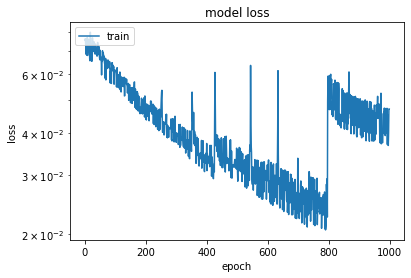

In [16]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(train_loss_arr)
plt.title('train model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.yscale('log')
# plt.savefig(path + '/' + 'test_loss.png')
plt.show()

In [ ]:
plt.plot(valid_loss_mean_arr)
plt.title('valid model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['valid'], loc='upper left')
plt.yscale('log')
# plt.savefig(path + '/' + 'test_loss.png')
plt.show()

In [56]:
model.eval() # eval mode
out, hidden = model(X_train)

In [57]:
for i in range(num_of_frames):
    print(str(i) + " -> " + str(torch.argmax(out[i])) + " -> " + str(torch.argmax(Y_train)))

0 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
1 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
2 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
3 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
4 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
5 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
6 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
7 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
8 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
9 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
10 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
11 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
12 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
13 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
14 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
15 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
16

164 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
165 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
166 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
167 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
168 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
169 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
170 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
171 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
172 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
173 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
174 -> tensor(2, device='cuda:0') -> tensor(0, device='cuda:0')
175 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
176 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
177 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
178 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
179 -> tensor(0, device='cuda:0') -> ten

322 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
323 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
324 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
325 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
326 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
327 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
328 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
329 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
330 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
331 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
332 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
333 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
334 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
335 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
336 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
337 -> tensor(3, device='cuda:0') -> ten

471 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
472 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
473 -> tensor(1, device='cuda:0') -> tensor(0, device='cuda:0')
474 -> tensor(1, device='cuda:0') -> tensor(0, device='cuda:0')
475 -> tensor(1, device='cuda:0') -> tensor(0, device='cuda:0')
476 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
477 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
478 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
479 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
480 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
481 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
482 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
483 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
484 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
485 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
486 -> tensor(0, device='cuda:0') -> ten

629 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
630 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
631 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
632 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
633 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
634 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
635 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
636 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
637 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
638 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
639 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
640 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
641 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
642 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
643 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
644 -> tensor(1, device='cuda:0') -> ten

780 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
781 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
782 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
783 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
784 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
785 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
786 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
787 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
788 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
789 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
790 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
791 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
792 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
793 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
794 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
795 -> tensor(0, device='cuda:0') -> ten

922 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
923 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
924 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
925 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
926 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
927 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
928 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
929 -> tensor(0, device='cuda:0') -> tensor(0, device='cuda:0')
930 -> tensor(1, device='cuda:0') -> tensor(0, device='cuda:0')
931 -> tensor(1, device='cuda:0') -> tensor(0, device='cuda:0')
932 -> tensor(1, device='cuda:0') -> tensor(0, device='cuda:0')
933 -> tensor(3, device='cuda:0') -> tensor(0, device='cuda:0')
934 -> tensor(2, device='cuda:0') -> tensor(0, device='cuda:0')
935 -> tensor(1, device='cuda:0') -> tensor(0, device='cuda:0')
936 -> tensor(1, device='cuda:0') -> tensor(0, device='cuda:0')
937 -> tensor(1, device='cuda:0') -> ten